# Authors:

* Yonatan Stekliar
* Aviram Shabtay
* Aviad Hedvat

# Imports & Installations

In [35]:
!git clone -q  https://github.com/Aviad-Hedvat/NLP_FinalProject
!pip install -q livelossplot

fatal: destination path 'NLP_FinalProject' already exists and is not an empty directory.


In [22]:
import os
import sys
import joblib
import pandas as pd

from NLP_FinalProject.FinalProject.ScrappingExtraction.DetailsExtraction import extract_ner
from NLP_FinalProject.FinalProject.Utils.TextUtils import html_scrape, list_of_words
from NLP_FinalProject.FinalProject.Utils.NerUtils import data_preparation, create_model, train, ner_predictions
from NLP_FinalProject.FinalProject.Utils.KeywordsUtils import keywords_extraction
from NLP_FinalProject.FinalProject.Utils.SentimentUtils import sentiment_prediction

# Preperations

In [4]:
project_path = '/content/NLP_FinalProject/FinalProject'
sys.path.append(project_path)
corpus_path = os.path.join(project_path, 'Corpus')

In [5]:
docs, raw_docs = {}, {}

for filename in os.listdir(corpus_path):
    filepath = os.path.join(corpus_path, filename)
    raw_docs[filename] = [" ".join(s.split()) for s in html_scrape(filepath)]
    docs[filename] = list_of_words(" ".join(raw_docs[filename]))

# Named Entity Recognition (NER)

In [7]:
docs_data, sentences_tags = extract_ner(raw_docs)

In [9]:
X, X_valid, t, t_valid, words_idx, tags_idx = data_preparation(sentences_tags)
longest_sen = max([len(sen) for sen in X])

In [11]:
model = create_model(longest_sen, len(words_idx), len(tags_idx))

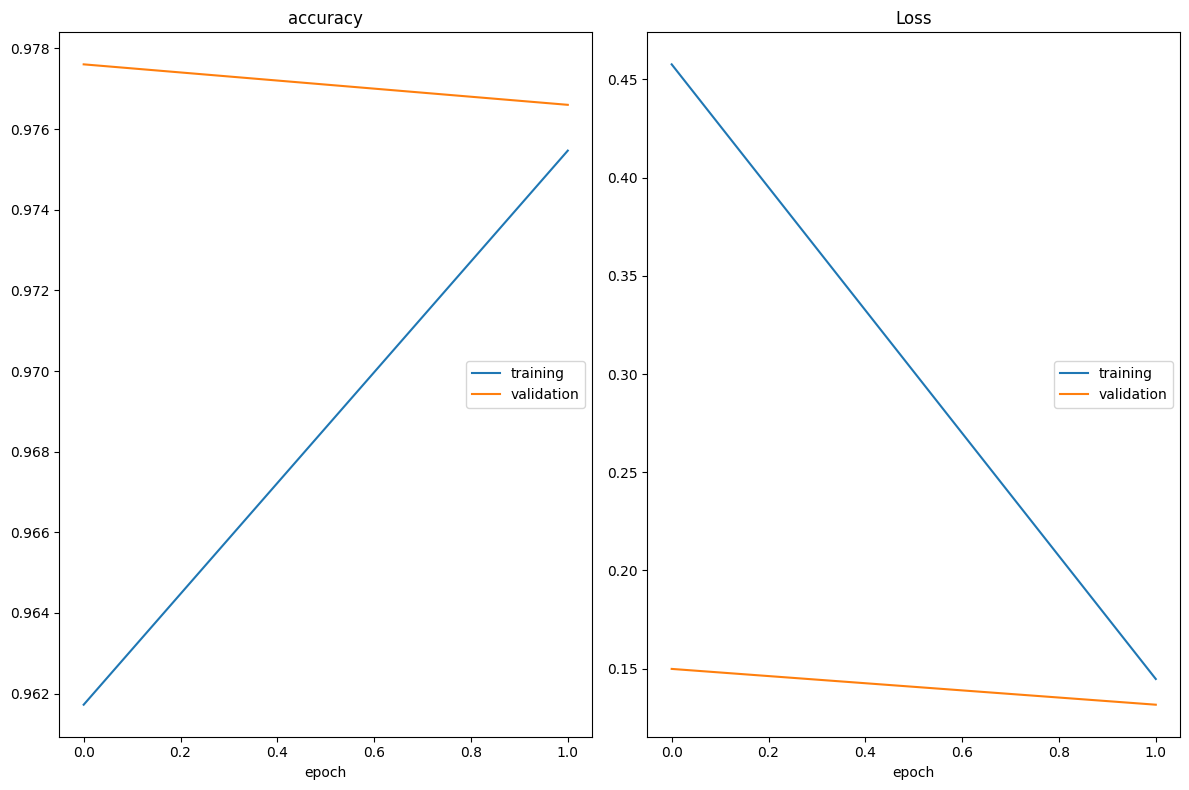

In [13]:
train(model, X, X_valid, t, t_valid)

In [16]:
predictions = ner_predictions(model, X, X_valid, t, t_valid, words_idx, tags_idx)

Generating Predictions:: 2071it [03:21, 10.29it/s]


In [18]:
ner = {
    "Word": [],
    "Tag": [],
    "Prediction": []
}

for batch in predictions:
    for b in batch:
        ner["Word"].append(b[0])
        ner["Tag"].append(b[1])
        ner["Prediction"].append(b[2])

ner_df = pd.DataFrame(ner)

ner_df.to_excel("NER_Results.xlsx", index=False)
ner_df

,Word,Tag,Prediction
0,המבקשת:,O,O
1,"מנורה חברה לביטוח בע""מ",Prosecutor,O
2,נ,O,O
3,פלוני,Defendant,O
4,פלונית,Defendant,O
...,...,...,...
103545,כך,O,O
103546,בפרט,O,O
103547,באשר,O,O
103548,להתייחסויות,O,O


# Keywords Extraction

extracting keywords by the following algorithms:
* TF-IDF
* WORD2VEC
* Recurrent Auto-encoder

## TF-IDF

In [19]:
tfidf_keywords = keywords_extraction(docs)

## WORD2VEC

In [24]:
w2v_keywords = keywords_extraction(docs, 2)

## Recurrent Auto-Encoder

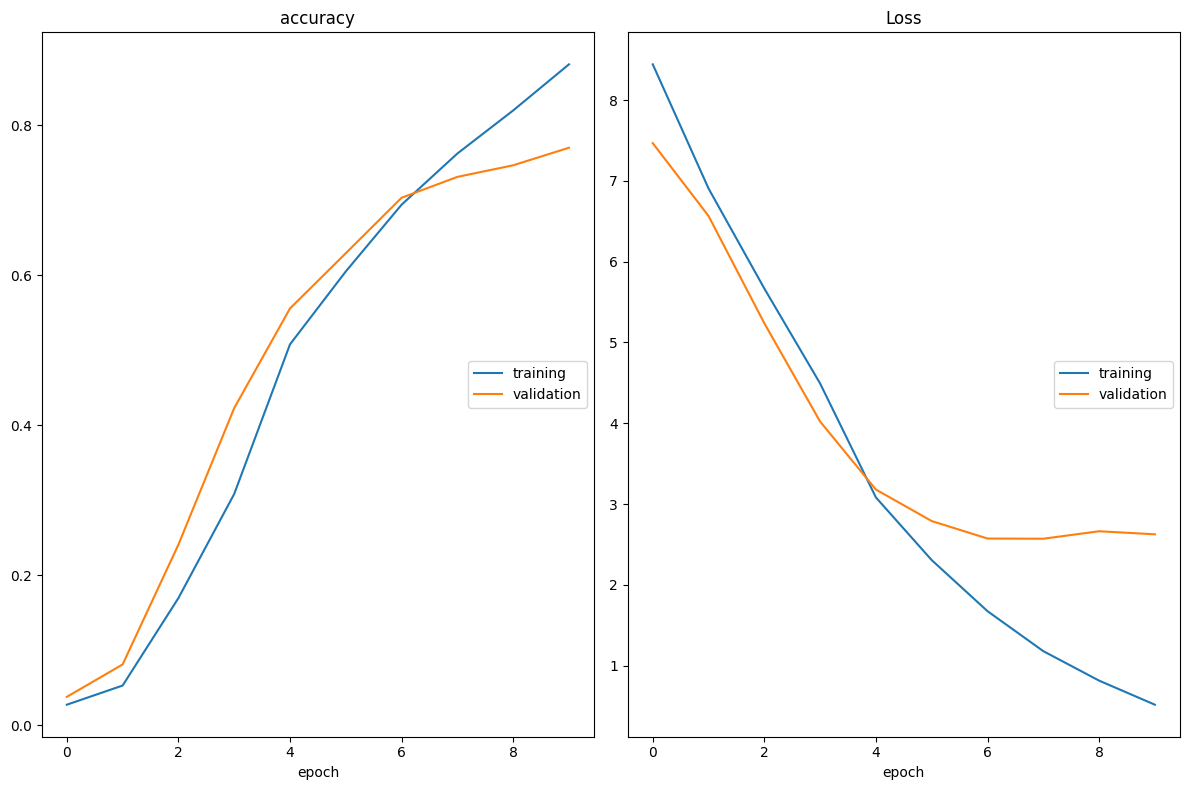

accuracy
	training         	 (min:    0.027, max:    0.881, cur:    0.881)
	validation       	 (min:    0.038, max:    0.770, cur:    0.770)
Loss
	training         	 (min:    0.517, max:    8.442, cur:    0.517)
	validation       	 (min:    2.571, max:    7.467, cur:    2.626)
149/149 [==============================] - 17s 114ms/step - loss: 0.5172 - accuracy: 0.8809 - val_loss: 2.6260 - val_accuracy: 0.7697


Generating Embeddings:: 100%|██████████| 199/199 [00:17<00:00, 11.65it/s]


In [21]:
autoencoder_keywords = keywords_extraction(docs, 3)

**in case u don't want to perform a model training u can load it**

In [36]:
project_path

'/content/NLP_FinalProject/FinalProject'

In [ ]:
# w2v_keywords = joblib.load('/content/NLP_FinalProject/FinalProject/Objects/w2v_keywords.params')
# # autoencoder_keywords = joblib.load('/content/NLP_FinalProject/FinalProject/Objects/autoencoder_keywords.params')

In [26]:
docs_data["Keywords"] = []
keywords = {
    "Document": [],
    "TF-IDF": [],
    "WORD2VEC": [],
    "AUTOENCODER": []
}

for name in docs_data["Document"]:
    docs_data["Keywords"].append(list(tfidf_keywords[name].keys()))
    keywords["Document"].append(name)

    for k, v in zip(
        ["TF-IDF", "WORD2VEC", "AUTOENCODER"],
        [tfidf_keywords, w2v_keywords, autoencoder_keywords]
    ):
        keywords[k].append(list(v[name].keys()))

keywords_df = pd.DataFrame(keywords)

keywords_df.to_excel("KEYWORDS_Results.xlsx", index=False)
keywords_df

,Document,TF-IDF,WORD2VEC,AUTOENCODER
0,23056710.O02.html,"[גבאר, טרבש, מעאד, שצ, הקבוע]","[‏ו, וילנר, אזולאי, יונתן, אחמד]","[שנים, התאונה, ערכאות, שנדרשו, בידיה]"
1,22005850.M12.html,"[השירות, עבודות, המערער, מיארה, קובו]","[ק, מרכז-לוד, בנצרת, בתפ""ח, בבאר]","[בקידום, כל, מדואל, עאצף, ההמלצות]"
2,23052370.M02.html,"[פאיד, מאזן, קולודני, ננ, לנשיאה]","[וילנר, ‏ו, אחמד, אזולאי, יונתן]","[בלתי-רצויות, בעמדות, אוטיזם, רוב, חניה]"
3,23059430.M02.html,"[גאסר, חמאדה, חוסין, ‏ג, אסתי]","[וילנר, ‏ו, אחמד, אזולאי, יונתן]","[מהמענה, בפנינו, שנכללו, קלסיק, הממונה]"
4,23057880.O02.html,"[סלימאן, וליד, מוסא, לבדה, הקבוע]","[וילנר, ‏ו, יונתן, אזולאי, משאלי]","[באמצעות, בסופו, לדקויות, מאחה, המועד]"
...,...,...,...,...
295,23056700.N01.html,"[מניעת, המפגש, מאהר, מוצטפא, מצרי]","[לתאורטית, אסמכתאות, נתבקשה, ‏ו, יונתן]","[שלשיטת, מסקנתנו, ניס, מקובלת, של]"
296,23059510.O02.html,"[רמדאן, תאמר, חסאן, נאצר, וכמוסכם]","[וילנר, ‏ו, אזולאי, משאלי, יונתן]","[אדנים, הוגשה, הרלוונטיות, בר""ם, הכנסת]"
297,22072070.O15.html,"[עמארנה, דמרי-בדש, מג'ד, לוטפי, נירון]","[אזולאי, ק, מרכז-לוד, וילנר, ליאור]","[הסגור, על-ידי, תיגבה, שהופרד, נשפוט]"
298,22089280.V08.html,"[מאק-קלמנוביץ, ליפשיץ-פרביס, עאטף, פרחאת, המערער]","[וילנר, ק, אזולאי, אלרון, מרכז-לוד]","[לביטול, מעודכן, לחברה, בעיבוד, מ-39]"


# Sentiment Analysis

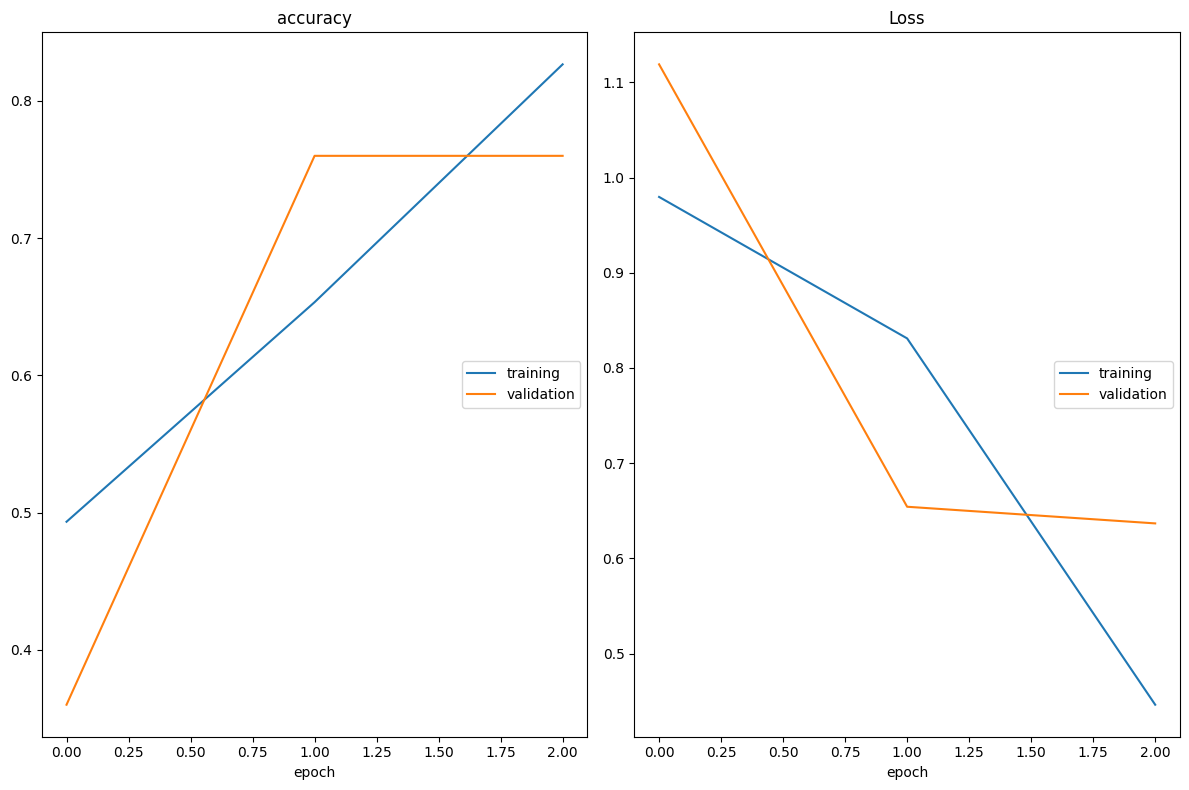

accuracy
	training         	 (min:    0.493, max:    0.827, cur:    0.827)
	validation       	 (min:    0.360, max:    0.760, cur:    0.760)
Loss
	training         	 (min:    0.446, max:    0.980, cur:    0.446)
	validation       	 (min:    0.637, max:    1.119, cur:    0.637)
225/225 [==============================] - 77s 343ms/step - loss: 0.4462 - accuracy: 0.8267 - val_loss: 0.6367 - val_accuracy: 0.7600


Generating Predictions:: 300it [01:33,  3.22it/s]


In [27]:
sentiment_preds, tags = sentiment_prediction(docs, raw_docs)

**in case u don't want to perform a model training u can load it**

In [ ]:
# sentiment_preds = joblib.load('/content/NLP_FinalProject/FinalProject/Objects/sentiment_predictions.pred')
# tag = joblib.load('/content/NLP_FinalProject/FinalProject/Objects/tags.tag)

In [28]:
docs_data["Sentiment"] = []
sentiment = {
    "Document": [],
    "Sentiment": [],
    "Prediction": []
}

for name in docs_data["Document"]:
    docs_data["Sentiment"].append(tags[name])

    sentiment["Document"].append(name)
    sentiment["Sentiment"].append(tags[name])
    sentiment["Prediction"].append(sentiment_preds[name])

sentiment_df = pd.DataFrame(sentiment)

sentiment_df.to_excel("SENTIMENT_Results.xlsx", index=False)
sentiment_df

,Document,Sentiment,Prediction
0,23056710.O02.html,NEUTRAL,NEUTRAL
1,22005850.M12.html,NEUTRAL,NEUTRAL
2,23052370.M02.html,NEUTRAL,NEUTRAL
3,23059430.M02.html,NEUTRAL,NEUTRAL
4,23057880.O02.html,NEUTRAL,NEGATIVE
...,...,...,...
295,23056700.N01.html,NEUTRAL,NEUTRAL
296,23059510.O02.html,NEUTRAL,NEUTRAL
297,22072070.O15.html,NEUTRAL,NEGATIVE
298,22089280.V08.html,NEGATIVE,NEGATIVE


#Results & Statistics

## MetaData

In [29]:
docs_data_df = pd.DataFrame(docs_data)
docs_data_df.to_excel('METADATA_Results.xlsx', index=False)
docs_data_df

,Document,Judges,Prosecutors,Defendants,Dates,Keywords,Sentiment
0,23056710.O02.html,"[כבוד השופט נ' סולברג, כבוד השופט ד' מינץ, כבו...",[מעאד עבד גבאר טרבש],"[ שופט צבאי משפטאי, המפקד הצבאי באיו""ש, שירו...",6.8.2023,"[גבאר, טרבש, מעאד, שצ, הקבוע]",NEUTRAL
1,22005850.M12.html,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופט ד' מי...",[אלעד מיארה],[מדינת ישראל],5.7.2023,"[השירות, עבודות, המערער, מיארה, קובו]",NEUTRAL
2,23052370.M02.html,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופט א' שט...",[מאזן מחמד פאיד],"[ שופט צבאי משפטאי, המפקד הצבאי באיו""ש, שירו...",21.8.2023,"[פאיד, מאזן, קולודני, ננ, לנשיאה]",NEUTRAL
3,23059430.M02.html,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופט א' שט...",[גאסר חוסין חמאדה],"[ שופט צבאי משפטאי, המפקד הצבאי באיו""ש, שירו...",20.8.2023,"[גאסר, חמאדה, חוסין, ‏ג, אסתי]",NEUTRAL
4,23057880.O02.html,"[כבוד השופט נ' סולברג, כבוד השופט ד' מינץ, כבו...",[וליד מוסא סלימאן אבו לבדה],"[ מפקד כוחות צה""ל באיו""ש, שופט בית המשפט הצבא...",3.8.2023,"[סלימאן, וליד, מוסא, לבדה, הקבוע]",NEUTRAL
...,...,...,...,...,...,...,...
295,23056700.N01.html,"[כבוד השופט ד' מינץ, כבוד השופטת י' וילנר, כבו...",[מאהר מוחמד מוצטפא מצרי],"[ שר הביטחון, שרות הביטחון הכללי]",25.7.2023,"[מניעת, המפגש, מאהר, מוצטפא, מצרי]",NEUTRAL
296,23059510.O02.html,"[כבוד השופט נ' סולברג, כבוד השופט ד' מינץ, כבו...",[תאמר נאצר מחמד רמדאן],[שירות הביטחון הכללי],6.8.2023,"[רמדאן, תאמר, חסאן, נאצר, וכמוסכם]",NEUTRAL
297,22072070.O15.html,"[כבוד השופט נ' סולברג, כבוד השופט ד' מינץ, כבו...",[המוסד לביטוח לאומי],"[ פורמלי עו""ד נדב שפירא - נאמן לחברה, מוראד ע...",31.7.2023,"[עמארנה, דמרי-בדש, מג'ד, לוטפי, נירון]",NEUTRAL
298,22089280.V08.html,"[כבוד הנשיאה א' חיות, כבוד השופט י' עמית, כבוד...",[פלוני],"[ מדינת ישראל, פלונית, פלונית, פלוני]",31.7.2023,"[מאק-קלמנוביץ, ליפשיץ-פרביס, עאטף, פרחאת, המערער]",NEGATIVE


In [30]:
from functools import reduce

judges = list(set(reduce(lambda x,y: x+y, docs_data["Judges"])))

judge_verdicts, keyword_freqs = {j: 0 for j in judges}, {}
judge_sentiment = {j: {"POSITIVE": 0, "NEGATIVE": 0, "NEUTRAL": 0} for j in judges}
count_sentiment = {"POSITIVE": 0, "NEGATIVE": 0, "NEUTRAL": 0}

for i in range(len(docs_data["Document"])):
    for j in docs_data["Judges"][i]:
        judge_verdicts[j] += 1
        judge_sentiment[j][docs_data["Sentiment"][i]] += 1

    for kw in docs_data["Keywords"][i]:
        keyword_freqs[kw] = keyword_freqs.get(kw, 0) + 1

    count_sentiment[docs_data["Sentiment"][i]] += 1

keyword_freqs = sorted(keyword_freqs.items(), key=lambda x: x[1], reverse=True)
keyword_freqs = {kw[0]: kw[1] for kw in keyword_freqs[:10]}

## Verdicts per judge count

In [31]:
judge_verdicts_df = pd.DataFrame.from_dict(judge_verdicts, orient='index', columns=['Verdicts'])
judge_verdicts_df

,Verdicts
כבוד השופטת י' וילנר,67
כבוד הרשמת קרן אזולאי,3
כבוד השופט נ' סולברג,68
כבוד השופטת ע' ברון,5
כבוד השופט ד' מינץ,94
כבוד השופטת ר' רונן,92
כבוד השופט י' אלרון,27
כבוד הנשיאה א' חיות,24
כבוד השופט ע' גרוסקופף,59
כבוד המשנה לנשיאה ע' פוגלמן,45


## Keywords frequencies

In [32]:
keyword_freqs_df = pd.DataFrame.from_dict(keyword_freqs, orient='index', columns=['Verdicts'])
keyword_freqs_df

,Verdicts
המערער,33
העותר,19
הצו,17
הצבאי,14
המערערת,13
לנשיאה,12
מניעת,12
העותרת,12
המערערים,11
מעצרו,10


## Sentiment per judge for each recorded verdict

In [33]:
judge_sentiment_df = pd.DataFrame.from_dict(judge_sentiment, orient='index')
judge_sentiment_df

,POSITIVE,NEGATIVE,NEUTRAL
כבוד השופטת י' וילנר,5,25,37
כבוד הרשמת קרן אזולאי,1,0,2
כבוד השופט נ' סולברג,6,30,32
כבוד השופטת ע' ברון,1,2,2
כבוד השופט ד' מינץ,8,48,38
כבוד השופטת ר' רונן,14,44,34
כבוד השופט י' אלרון,6,12,9
כבוד הנשיאה א' חיות,2,14,8
כבוד השופט ע' גרוסקופף,8,32,19
כבוד המשנה לנשיאה ע' פוגלמן,2,21,22


## Classify verdicts by sentiment

In [34]:
count_sentiment_df = pd.DataFrame.from_dict(count_sentiment, orient='index')
count_sentiment_df

,0
POSITIVE,30
NEGATIVE,151
NEUTRAL,119
